In [1]:
import json
import pandas as pd
import tensorflow as tf

file1='Sarcasm_Headlines_Dataset.json'
#with open(file1, 'r') as f:
#    datastore=json.load(f)
news = pd.read_json('Sarcasm_Headlines_Dataset.json',lines=True)
news.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [2]:
news.describe()

,is_sarcastic
count,26709.000000
mean,0.438953
std,0.496269
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [3]:
columns=news.columns
print(columns)
print(type(columns))
print(type(news.headline))

Index(['article_link', 'headline', 'is_sarcastic'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.series.Series'>


In [4]:
import numpy as np
sentences=news.headline.tolist()
labels=news.is_sarcastic.to_numpy()

In [26]:
vocab_size=2000
embedding_dim=16
max_length=32
trunc_type='post'
padding_type='post'
oov_tok="<oov>"
training_size=20000

In [27]:
training_sentences=sentences[0:training_size]
testing_sentences=sentences[training_size:]
training_labels=labels[0:training_size]
testing_labels=labels[training_size:]

In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer=Tokenizer(num_words=vocab_size, oov_token="<oov>")
tokenizer.fit_on_texts(training_sentences)
word_index=tokenizer.word_index
#print(word_index)
#print(len(word_index))
training_sequences=tokenizer.texts_to_sequences(training_sentences)
testing_sequences=tokenizer.texts_to_sequences(testing_sentences)

In [29]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

training_padded=pad_sequences(training_sequences, maxlen=max_length,
                              padding=padding_type, truncating=trunc_type)
testing_padded=pad_sequences(testing_sequences, maxlen=max_length,
                              padding=padding_type, truncating=trunc_type)

In [35]:
#regularizer=tf.keras.regularizers.l2(0.01)

model=tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
#   tf.keras.layers.Flatten(),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(24, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-2, l2=1e-1),
    bias_regularizer=tf.keras.regularizers.l2(1e-3),
    activity_regularizer=tf.keras.regularizers.l2(1e-3)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 32, 16)            32000     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 24)                408       
_________________________________________________________________
dropout_4 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 25        
Total params: 32,433
Trainable params: 32,433
Non-trainable params: 0
_________________________________________________________________


In [36]:
num_epochs=20
history=model.fit(training_padded, training_labels,epochs=num_epochs, batch_size=32, validation_data=(testing_padded, testing_labels))

Epoch 1/20
625/625 [==============================] - 3s 3ms/step - loss: 1.8754 - accuracy: 0.5607 - val_loss: 0.6668 - val_accuracy: 0.5633

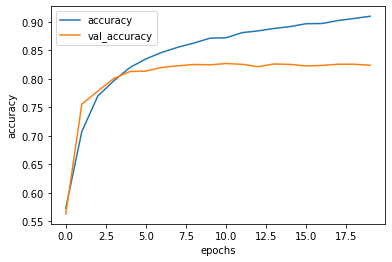

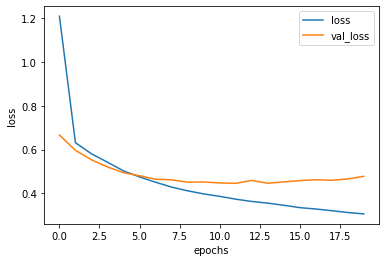

In [37]:
import matplotlib.pyplot as plt

def plot_graph(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graph(history, "accuracy")
plot_graph(history, "loss")